# Bibliotecas

In [2]:
%matplotlib inline

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math

from quickda.explore_data import *
from quickda.clean_data import *
from quickda.explore_numeric import *
from quickda.explore_categoric import *
from quickda.explore_numeric_categoric import *
from quickda.explore_time_series import *

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import SGDRegressor, LinearRegression, HuberRegressor, Ridge, RidgeCV, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Funções Auxiliares

In [3]:
def percentual_outlier(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
    num_outliers =  np.sum((data < minimum) | (data > maximum))
    num_total = data.count()
    return (num_outliers/num_total)*100

def plot_history(history):
    mse = history.history['mse']
    val_mse = history.history['val_mse']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(mse) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    #plt.ylim(0,6000000000)
    plt.plot(x, mse, 'b', label='MSE Treino')
    plt.plot(x, val_mse, 'r', label='MSE Validação')
    plt.title('Treino e Validação - MSE')
    plt.legend()
    plt.subplot(1, 2, 2)
    #plt.ylim(0,100000)
    plt.plot(x, loss, 'b', label='Loss Treino')
    plt.plot(x, val_loss, 'r', label='Loss Validação')
    plt.title('Treino e Validação - Loss')
    plt.legend()

# Carregando os Dados
## dados pré processados no notebook de análises de dados

In [4]:
df = pd.read_csv("./df_pre_processado.csv")

In [5]:
df.head(10)

numero_solicitacao             razaoSocial        nomeFantasia  \
0                   1  James Richardson-Patel  Alexandra Williams   
1                   3           Joanna Hudson      Dr. David Rees   
2                   5               Nigel Lee  Dr. Stanley Duncan   
3                   7   Alexander Baker-Wells    Dr. Caroline Ali   
4                   8              Jean Berry       Gregory Gould   
5                   9       Elliot Stephenson       Adrian Graham   
6                  10         Dr. Dale Dawson       Caroline Hale   
7                  11            Katie Lawson   Patricia Reynolds   
8                  12            Ellie Turner       Mohamed Welch   
9                  14              Nicole Fry        Lewis Harris   

         cnpjSemTraco  maiorAtraso  margemBrutaAcumulada  percentualProtestos  \
0  KEBE17609492220843            0              0.252448                  0.0   
1  GCVQ28531614261293            4              0.624777                  0.0   
2  CGQN15826802440348           20              0.454088                  0.0   
3  PYOL43118620147076           16              0.000000                  NaN   
4  NLUX93496216176463            4              0.350175                  0.0   
5  LOVL82962402474134           43              0.245818                  0.0   
6  NXKJ36775578171965           24              0.000012                  0.0   
7  SVXA16230297135119            7              0.000000                  NaN   
8  ELQK41348591516215           26              0.000000                  NaN   
9  PVQV57475295829119           52              0.000000                  NaN   

        primeiraCompra  prazoMedioRecebimentoVendas  titulosEmAberto  ...  \
0  2015-12-10T00:00:00                            0             0.00  ...   
1  2019-11-27T00:00:00                            0             0.00  ...   
2  2010-07-13T00:00:00                           20          1486.95  ...   
3  2011-03-02T11:27:13                            0             0.00  ...   
4  2007-07-02T00:00:00                          102        208980.00  ...   
5  2006-07-10T00:00:00                           27          6432.00  ...   
6  2011-02-24T00:00:00                            0         22733.33  ...   
7  2012-02-24T16:01:26                            0             0.00  ...   
8  2017-12-20T17:03:32                            0             0.00  ...   
9  2006-05-01T13:18:05                            0             0.00  ...   

   periodoDemonstrativoEmMeses       custos anoFundacao  intervaloFundacao  \
0                         12.0          0.0      2003.0   Acima de 17 anos   
1                          7.0          0.0      2014.0     De 6 a 10 anos   
2                          9.0   40680051.0      2002.0   Acima de 17 anos   
3                         12.0  156394112.0      1982.0   Acima de 17 anos   
4                          9.0          0.0      2000.0   Acima de 17 anos   
5                         12.0  -49267738.0      2000.0   Acima de 17 anos   
6                         12.0   15322217.0      1996.0   Acima de 17 anos   
7                          6.0   -3299332.0      2011.0     De 6 a 10 anos   
8                         12.0   -9455401.0      2009.0    De 11 a 16 anos   
9                          9.0    3366929.0      2003.0   Acima de 17 anos   

   capitalSocial  restricoes  empresa_MeEppMei scorePontualidade  \
0        90000.0       False              True           1.00000   
1        20000.0       False              True           1.00000   
2        75000.0       False             False           1.00000   
3     30515674.0        True             False           0.00000   
4       120000.0       False             False           1.00000   
5      1000000.0       False             False           1.00000   
6        80000.0       False              True           0.83159   
7        20000.0       False              True           0.00000   
8       600000.0       False    

<h3>
Nesta análise vamos usar a variável "valorAprovado" como target para a regressão.<BR>
Portanto vamos trabalhar apenas com os dados que possuem este valor, ou seja, os clientes que tiveram o seu crédito aprovado.<BR>
</h3>

In [6]:
df = df[~(df.valorAprovado.isnull())]

<h3>
Vamos retirar agora as variáveis categóricas e de data que não serão utilizadas para este modelo de regressão.<BR>
Vamos tambem retirar algumas outras varáveis:<BR>
1) numero_solicitação - não necessitamos de um index.<BR>
2) percentualProtestos - esta variável náo ajuda a explicar o problema pois possue 83% de zeros e 16,7% de nulos. Sobrando apenas 0,3% de dados válidos.<BR>
3) diferencaPercentualRisco - mesmos valores do percentualRisco.<BR>
4) dashboardCorrelacao - Não entedemos o seu objetivo.<BR>
5) As duas booleanas - 'restricoes', 'empresa_MeEppMei'<BR>
</h3>

In [7]:
df_num = df.drop(['cnpjSemTraco', 'dataAprovadoEmComite', 'percentualProtestos', 'dataAprovadoNivelAnalista', 'numero_solicitacao', 'razaoSocial', 'nomeFantasia', 'anoFundacao', 'status', 'definicaoRisco', 'diferencaPercentualRisco', 'dashboardCorrelacao',
         'periodoBalanco', 'primeiraCompra', 'intervaloFundacao', 'periodoDemonstrativoEmMeses', 'restricoes', 'empresa_MeEppMei'], axis=1)

In [8]:
df_num.shape

(5095, 20)

In [9]:
explore(df_num)

dtypes  count  null_sum  null_pct  nunique  \
maiorAtraso                    int64   5095         0       0.0      149   
margemBrutaAcumulada         float64   5095         0       0.0     1168   
prazoMedioRecebimentoVendas    int64   5095         0       0.0      147   
titulosEmAberto              float64   5095         0       0.0      560   
valorSolicitado              float64   5095         0       0.0      298   
percentualRisco              float64   5095         0       0.0       74   
valorAprovado                float64   5095         0       0.0      287   
ativoCirculante              float64   5095         0       0.0     1718   
passivoCirculante            float64   5095         0       0.0     1715   
totalAtivo                   float64   5095         0       0.0     1713   
totalPatrimonioLiquido       float64   5095         0       0.0     1688   
endividamento                float64   5095         0       0.0     1146   
duplicatasAReceber           float64   5095         0       0.0     1604   
estoque                      float64   5095         0       0.0     1607   
faturamentoBruto             float64   5095         0       0.0     2480   
margemBruta                  float64   5095         0       0.0     1775   
custos                       float64   5095         0       0.0     1631   
capitalSocial                float64   5095         0       0.0      293   
scorePontualidade            float64   5095         0       0.0      281   
limiteEmpresaAnaliseCredito  float64   5095         0       0.0     1440   

                                     min          25%          50%  \
maiorAtraso                          0.0        3.000        8.000   
margemBrutaAcumulada                 0.0        0.292        0.405   
prazoMedioRecebimentoVendas          0.0        0.000        0.000   
titulosEmAberto                      0.0        0.000     2918.750   
valorSolicitado                    100.0    40000.000    70000.000   
percentualRisco                      0.0        0.143        0.232   
valorAprovado                        0.0    25000.000    50000.000   
ativoCirculante                    -17.0   630894.500  3319814.000   
passivoCirculante              -355509.0   120543.500  1155866.000   
totalAtivo                         -17.0   779588.000  3954907.000   
totalPatrimonioLiquido      -186719734.0   143447.000  1384159.000   
endividamento                        0.0        0.000        0.000   
duplicatasAReceber           -22780710.0     1653.000   917929.000   
estoque                        -263226.0   112094.000   923371.000   
faturamentoBruto                     0.0  2056741.000  6875327.000   
margemBruta                 -614872100.0        0.000  1526626.000   
custos                      -346633805.0        0.000  1924418.000   
capitalSocial                        0.0    95400.000   200000.000   
scorePontualidade                    0.0        0.894        1.000   
limiteEmpresaAnaliseCredito          0.0    11100.000    89100.000   

                                      75%           max          mean  \
maiorAtraso                  2.500000e+01  9.770000e+02  2.700400e+01   
margemBrutaAcumulada         5.040000e-01  1.000000e+00  3.640000e-01   
prazoMedioRecebimentoVendas  3.700000e+01  1.605000e+03  2.829600e+01   
titulosEmAberto              3.994417e+04  2.836656e+06  8.543531e+04   
valorSolicitado              2.375000e+05  1.200000e+09  6.683094e+05   
percentualRisco              3.210000e-01  7.360000e-01  2.410000e-01   
valorAprovado                1.900000e+05  6.550000e+06  2.373725e+05   
ativoCirculante              1.424620e+07  2.903832e+10  4.073206e+07   
passivoCirculante            6.548251e+06  2.750382e+10  3.122290e+07   
totalAtivo                   1.758751e+07  5.482350e+10  6.472294e+07   
totalPatrimonioLiquido       7.283365e+06  1.292328e+10  2.597326e+07   
endividamento                6.216420e+05  7.406315e+08  4.289277e+06   
duplicatasARe

<h1>Modelo de Regressão Linear</h1>
<h2>
Vamos analisar o percentual de Extremos (Outliers) que temos em nossa base, pois modelos de regressão não performam bem na presença de valores extremos.
</h2>

In [10]:
for coluna in df_num.columns:
    data = df_num[coluna]
    perc = str(round(percentual_outlier(data), 2))
    print(f'Outliers na coluna {coluna} : {perc}%')

Outliers na coluna maiorAtraso : 11.27%
Outliers na coluna margemBrutaAcumulada : 0.12%
Outliers na coluna prazoMedioRecebimentoVendas : 5.99%
Outliers na coluna titulosEmAberto : 16.13%
Outliers na coluna valorSolicitado : 12.44%
Outliers na coluna percentualRisco : 0.47%
Outliers na coluna valorAprovado : 13.09%
Outliers na coluna ativoCirculante : 12.97%
Outliers na coluna passivoCirculante : 14.45%
Outliers na coluna totalAtivo : 13.29%
Outliers na coluna totalPatrimonioLiquido : 13.82%
Outliers na coluna endividamento : 17.98%
Outliers na coluna duplicatasAReceber : 12.86%
Outliers na coluna estoque : 13.54%
Outliers na coluna faturamentoBruto : 13.6%
Outliers na coluna margemBruta : 13.39%
Outliers na coluna custos : 14.43%
Outliers na coluna capitalSocial : 14.62%
Outliers na coluna scorePontualidade : 19.39%
Outliers na coluna limiteEmpresaAnaliseCredito : 16.72%


<h3>
Como podemos ver acima temos uma quantidade considerável de extremos. Vamos retirá-los abaixo.
</h3>

In [11]:
for column in df_num.columns:
    data = df_num[column]
    
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
 
    outliers = ((data < minimum) | (data > maximum))
    df_num[column].loc[outliers] = np.nan
    
df_num.dropna(inplace=True)    

In [12]:
explore(df_num)

dtypes  count  null_sum  null_pct  nunique  \
maiorAtraso                  float64   2192         0       0.0       48   
margemBrutaAcumulada         float64   2192         0       0.0      707   
prazoMedioRecebimentoVendas  float64   2192         0       0.0       78   
titulosEmAberto              float64   2192         0       0.0      273   
valorSolicitado              float64   2192         0       0.0      135   
percentualRisco              float64   2192         0       0.0       64   
valorAprovado                float64   2192         0       0.0      119   
ativoCirculante              float64   2192         0       0.0      716   
passivoCirculante            float64   2192         0       0.0      702   
totalAtivo                   float64   2192         0       0.0      712   
totalPatrimonioLiquido       float64   2192         0       0.0      703   
endividamento                float64   2192         0       0.0      366   
duplicatasAReceber           float64   2192         0       0.0      612   
estoque                      float64   2192         0       0.0      652   
faturamentoBruto             float64   2192         0       0.0     1186   
margemBruta                  float64   2192         0       0.0      718   
custos                       float64   2192         0       0.0      662   
capitalSocial                float64   2192         0       0.0      119   
scorePontualidade            float64   2192         0       0.0      107   
limiteEmpresaAnaliseCredito  float64   2192         0       0.0      643   

                                     min          25%          50%  \
maiorAtraso                        0.000        3.000        5.000   
margemBrutaAcumulada               0.000        0.344        0.426   
prazoMedioRecebimentoVendas        0.000        0.000        0.000   
titulosEmAberto                    0.000        0.000     1411.660   
valorSolicitado                 3000.000    30000.000    50000.000   
percentualRisco                    0.000        0.161        0.250   
valorAprovado                     10.000    17000.000    35000.000   
ativoCirculante                  -17.000    52461.000  1065790.000   
passivoCirculante            -355509.000      431.250   258756.000   
totalAtivo                       -17.000    64559.000  1238843.000   
totalPatrimonioLiquido      -1828715.000        0.000   487751.000   
endividamento                      0.000        0.000        0.000   
duplicatasAReceber                 0.000        0.000   153402.000   
estoque                            0.000        0.000   294650.000   
faturamentoBruto                   0.000  1177704.250  2893612.500   
margemBruta                 -2846171.000        0.000   279149.000   
custos                      -7036474.000        0.000   235486.000   
capitalSocial                      0.000    50000.000   100000.000   
scorePontualidade                  0.737        1.000        1.000   
limiteEmpresaAnaliseCredito        0.000     7040.000    34030.000   

                                     75%           max         mean  \
maiorAtraso                       17.000  5.800000e+01       10.085   
margemBrutaAcumulada               0.515  7.460000e-01        0.423   
prazoMedioRecebimentoVendas       28.000  9.000000e+01       14.739   
titulosEmAberto                15105.575  9.734226e+04    11799.474   
valorSolicitado                88000.000  5.000000e+05    69413.464   
percentualRisco                    0.357  5.890000e-01        0.260   
valorAprovado                  60000.000  4.200000e+05    50692.069   
ativoCirculante              3174571.500  2.575299e+07  2405951.494   
passivoCirculante            1021939.000  1.527940e+07   878989.992   
totalAtivo                   3517355.000  3.060126e+07  2703113.227   
totalPatrimonioLiquido       1712144.750  1.753293e+07  1481115.678   
endividamento                  50789.000  1.551513e+06   102417.705   
duplicatasAReceber            999026.00

<h3>
Agora vamos analisar o gráfico de cada variável contra a nossa variável TARGET (valorAprovado) para entendermos a relação entre elas.
</h3>

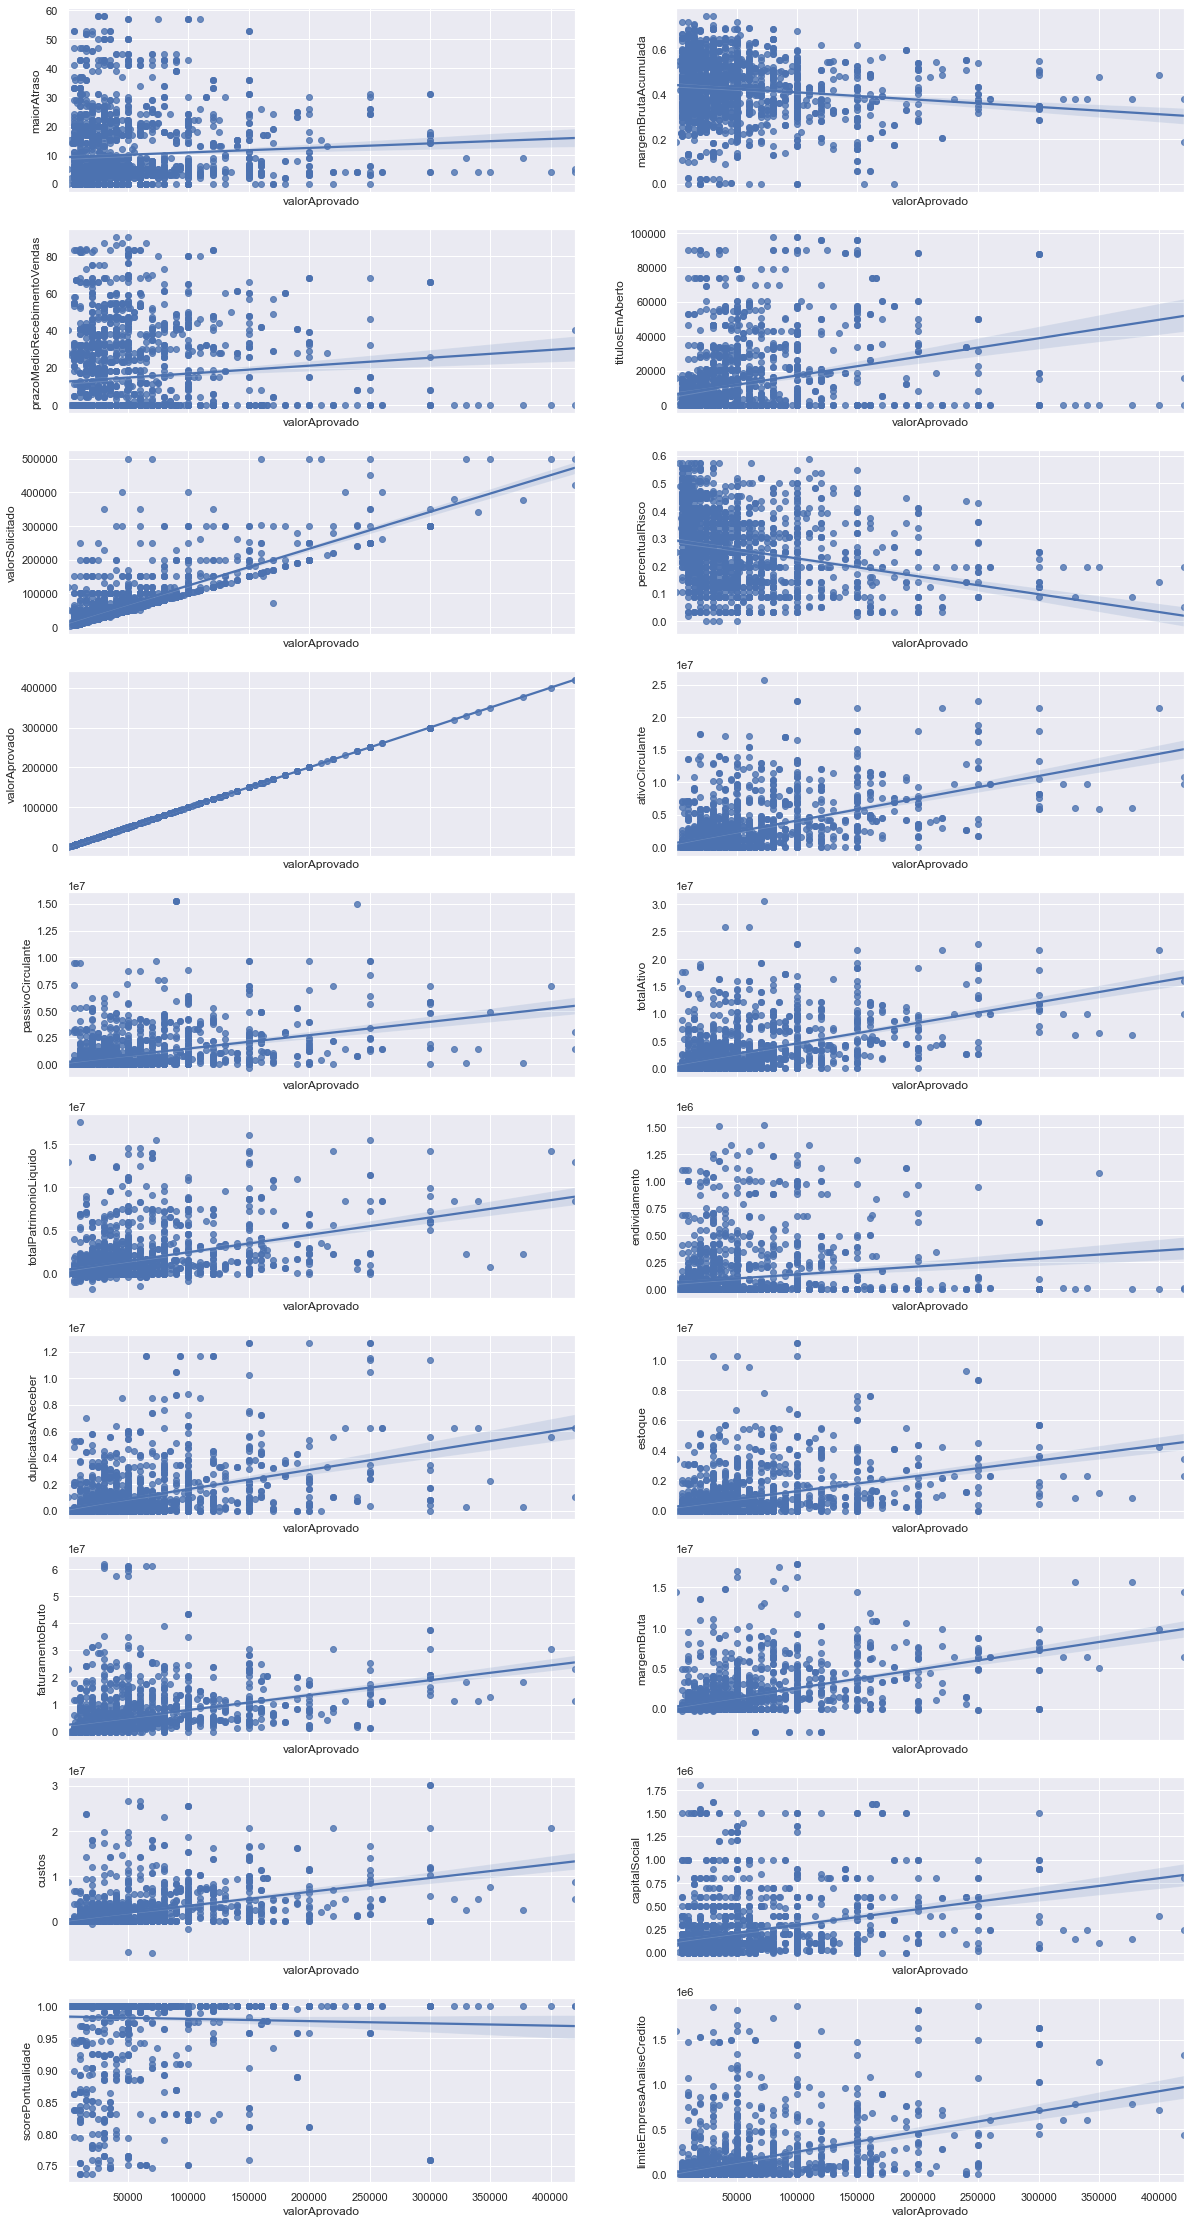

In [13]:
nc = 2
nl = 10
fig, axes = plt.subplots(nl, nc, sharex=True, figsize=(20,40))
coluna = 0
for x in range(10):
    for y in range(2):
        sns.regplot(x=df_num.valorAprovado, y=df_num.iloc[:,coluna], ax=axes[x,y])
        coluna += 1
    
plt.show()    

<h3>
Mapa de correlações
</h3>

<AxesSubplot:>

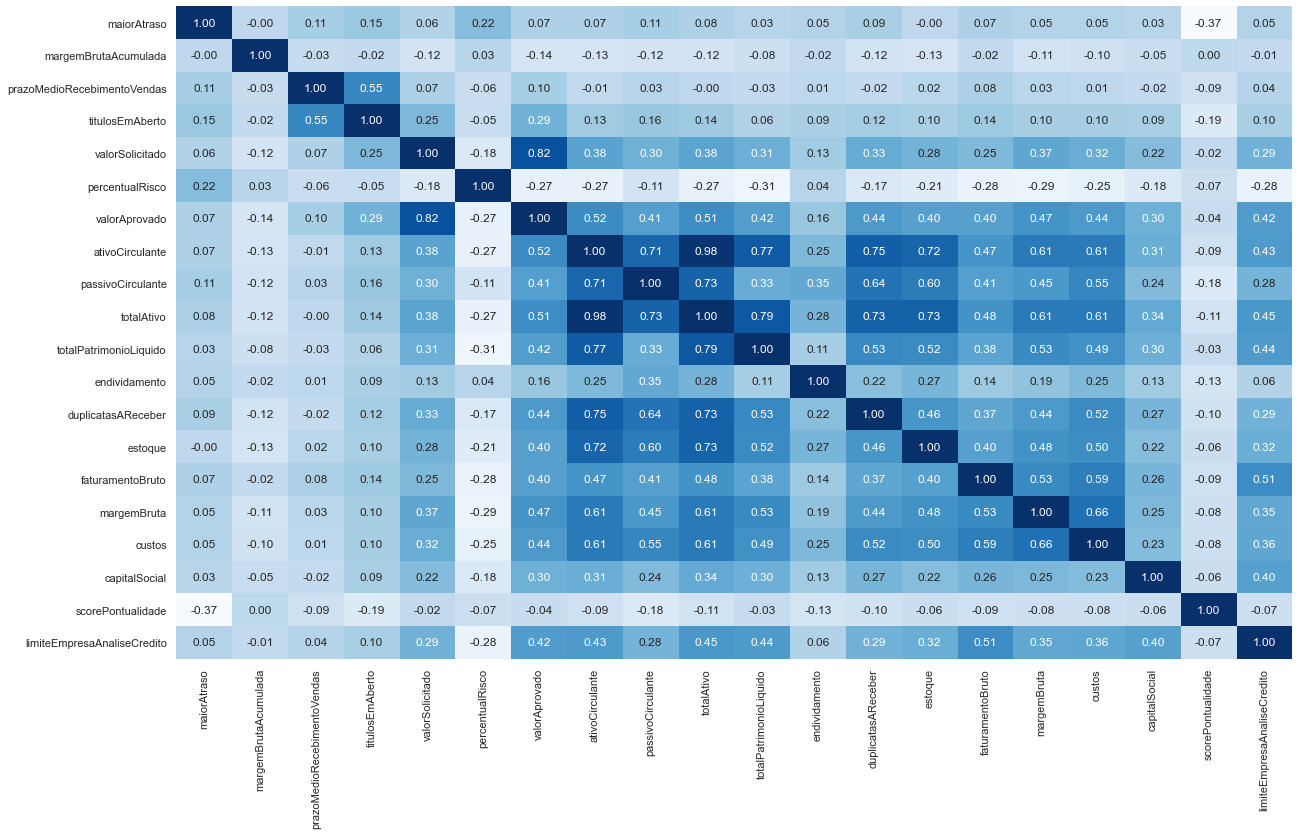

In [14]:
fig = plt.figure(figsize=(20,12))
sns.heatmap(df_num.corr(), cmap='Blues', annot=True, cbar=False, fmt='0.2f')

In [15]:
df_num = df_num.drop(['endividamento', 'scorePontualidade', 'margemBrutaAcumulada', 'ativoCirculante', 
                         'passivoCirculante', 'duplicatasAReceber'], axis=1)

In [16]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2192 entries, 0 to 6009
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   maiorAtraso                  2192 non-null   float64
 1   prazoMedioRecebimentoVendas  2192 non-null   float64
 2   titulosEmAberto              2192 non-null   float64
 3   valorSolicitado              2192 non-null   float64
 4   percentualRisco              2192 non-null   float64
 5   valorAprovado                2192 non-null   float64
 6   totalAtivo                   2192 non-null   float64
 7   totalPatrimonioLiquido       2192 non-null   float64
 8   estoque                      2192 non-null   float64
 9   faturamentoBruto             2192 non-null   float64
 10  margemBruta                  2192 non-null   float64
 11  custos                       2192 non-null   float64
 12  capitalSocial                2192 non-null   float64
 13  limiteEmpresaAnali

In [17]:
x = df_num.drop('valorAprovado', axis=1)
y = df_num.valorAprovado

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [18]:
lm = LinearRegression(normalize=True)
linear = lm.fit(x_train, y_train)
y_pred = linear.predict(x_test)
print(f"R2 score do treino: {round(linear.score(x_train, y_train), 4)}")
print(f"R2 score do teste: {round(linear.score(x_test, y_test), 4)}")
print(f"MAE do teste: {round(mean_absolute_error(y_test, y_pred), 2)}")
print(f"RMSE do teste: {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}")

R2 score do treino: 0.7457
R2 score do teste: 0.7871
MAE do teste: 16169.71
RMSE do teste: 26363.03


In [19]:
index_amostra = [15, 78, 189, 276, 380]
for x in index_amostra:
    amostra = np.array(x_test.iloc[x,:]).reshape(1,-1)
    previsao = linear.predict(amostra)
    print(f"Previsão: {round(previsao[0],2)} x Real: {y_test.iloc[x]} - erro {round(y_test.iloc[x] - round(previsao[0],2),2)}")

Previsão: 37485.28 x Real: 20000.0 - erro -17485.28
Previsão: 176632.15 x Real: 180000.0 - erro 3367.85
Previsão: 31128.7 x Real: 30000.0 - erro -1128.7
Previsão: 24877.1 x Real: 35000.0 - erro 10122.9
Previsão: 25282.18 x Real: 10000.0 - erro -15282.18


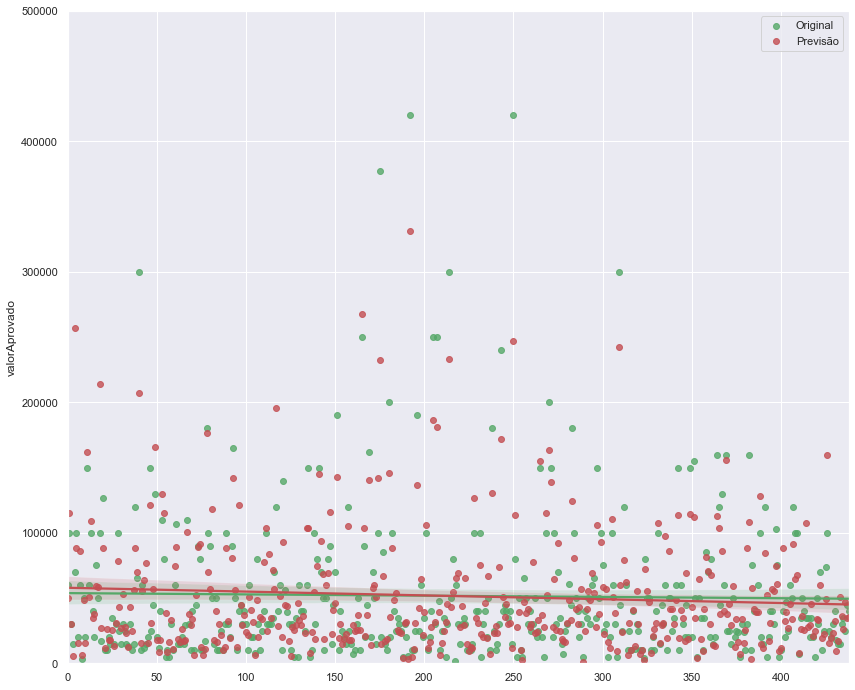

In [20]:
fig = plt.figure(figsize=(14,12))
xrange = list(range(len(y_test)))
sns.regplot(x=xrange, y=y_test, color='g', truncate=True, label='Original')
sns.regplot(x=xrange, y=y_pred, color='r', truncate=True, label='Previsão')
plt.legend()
plt.ylim(0,500000)
plt.show()

In [21]:
ridge = Ridge()
lin_rdg = ridge.fit(x_train, y_train)
y_pred = lin_rdg.predict(x_test)
print(f"R2 score do treino: {round(lin_rdg.score(x_train, y_train), 4)}")
print(f"R2 score do teste: {round(lin_rdg.score(x_test, y_test), 4)}")
print(f"MAE do teste: {round(mean_absolute_error(y_test, y_pred), 2)}")
print(f"RMSE do teste: {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}")

R2 score do treino: 0.7457
R2 score do teste: 0.7871
MAE do teste: 16166.04
RMSE do teste: 26362.98


In [22]:
elastic = ElasticNet()
lin_elastic = elastic.fit(x_train, y_train)
y_pred = lin_elastic.predict(x_test)
print(f"R2 score do treino: {round(lin_elastic.score(x_train, y_train), 4)}")
print(f"R2 score do teste: {round(lin_elastic.score(x_test, y_test), 4)}")
print(f"MAE do teste: {round(mean_absolute_error(y_test, y_pred), 2)}")
print(f"RMSE do teste: {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}")

R2 score do treino: 0.7437
R2 score do teste: 0.7858
MAE do teste: 16231.94
RMSE do teste: 26448.11


<h1>MLP</h1>

In [23]:
x = df_num.drop('valorAprovado', axis=1)
y = df_num.valorAprovado

ssc = StandardScaler()
x_ssc = ssc.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_ssc, y, test_size=0.2, random_state=42)

In [24]:
x.shape

(2192, 13)

In [25]:
model = Sequential()
model.add(Dense(256, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))

In [26]:
checkpointer = ModelCheckpoint(filepath='./modelo_mlp_ex3.hdf5', verbose=1, save_best_only=True, monitor='val_mae')

model.compile(loss='mae', optimizer='adam', metrics=['mse', 'mae'])
#history = model.fit(x_train, y_train, epochs=250, batch_size=16, validation_split=0.1, callbacks=[checkpointer])
history = model.fit(x_train, y_train, epochs=250, batch_size=16, validation_data=(x_test, y_test), callbacks=[checkpointer])

Epoch 1/250
 92/110 [========================>.....] - ETA: 0s - loss: 42888.7656 - mse: 4020724480.0000 - mae: 42888.7656
Epoch 00001: val_mae improved from inf to 28386.64453, saving model to .\modelo_mlp_ex3.hdf5
110/110 [==============================] - 0s 4ms/step - loss: 40574.7773 - mse: 3651255552.0000 - mae: 40574.7773 - val_loss: 28386.6445 - val_mse: 1998779648.0000 - val_mae: 28386.6445
Epoch 2/250
 88/110 [=======================>......] - ETA: 0s - loss: 23727.5781 - mse: 1421445376.0000 - mae: 23727.5781
Epoch 00002: val_mae improved from 28386.64453 to 20711.65234, saving model to .\modelo_mlp_ex3.hdf5
110/110 [==============================] - 0s 3ms/step - loss: 22959.0781 - mse: 1315246592.0000 - mae: 22959.0781 - val_loss: 20711.6523 - val_mse: 980564160.0000 - val_mae: 20711.6523
Epoch 3/250
 88/110 [=======================>......] - ETA: 0s - loss: 20184.5957 - mse: 962944640.0000 - mae: 20184.5957
Epoch 00003: val_mae improved from 20711.65234 to 18063.39453, sa

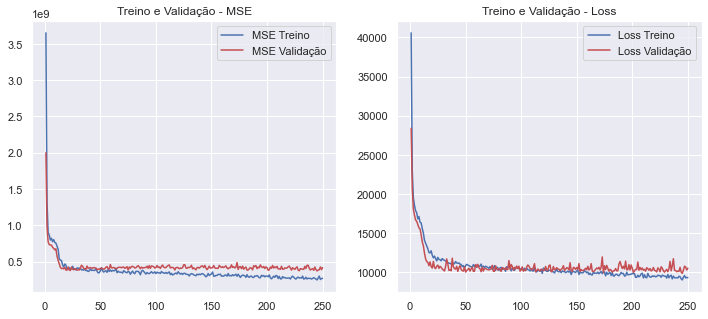

In [27]:
plot_history(history)

In [28]:
model = load_model("./modelo_mlp_ex3.hdf5")

In [29]:
y_pred = model.predict(x_test)
y_p_train = model.predict(x_train)

In [30]:
print(f"R2 score do treino: {round(r2_score(y_train, y_p_train), 4)}")
print(f"R2 score do teste: {round(r2_score(y_test, y_pred), 4)}")
print(f"MAE do teste: {round(mean_absolute_error(y_test, y_pred), 2)}")
print(f"RMSE do teste: {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}")


R2 score do treino: 0.9248
R2 score do teste: 0.8861
MAE do teste: 9863.74
RMSE do teste: 19288.67


In [31]:
x_test

array([[-0.43019727, -0.12841573, -0.00674852, ..., -0.51337117,
        -0.47100228, -0.13297757],
       [-0.51480093, -0.69101523, -0.59959642, ...,  6.44548968,
        -0.23206964, -0.33195973],
       [-0.43019727,  1.74691592,  1.76338569, ..., -0.4972817 ,
         0.27992889, -0.47055801],
       ...,
       [-0.85321558, -0.3159489 , -0.09144123, ..., -0.35096731,
        -0.40273581, -0.3771626 ],
       [-0.34559361,  1.46561617,  0.05189208, ...,  0.11902536,
        -0.64166846, -0.4401781 ],
       [ 1.00806499,  1.18431642,  0.65327393, ...,  0.36039758,
        -0.40273581, -0.27189809]])

In [88]:
index_amostra = [15, 78, 189, 276, 380]
for x in index_amostra:
    amostra = x_test[x].reshape(1,-1)
    previsao = model.predict(amostra)
    print(f"Previsão: {round(previsao[0][0],2)} x Real: {y_test.iloc[x]} - erro {round(y_test.iloc[x] - round(previsao[0][0],2),2)}")

Previsão: 40125.80859375 x Real: 20000.0 - erro -20125.81
Previsão: 167442.65625 x Real: 180000.0 - erro 12557.34
Previsão: 32490.349609375 x Real: 30000.0 - erro -2490.35
Previsão: 30878.16015625 x Real: 35000.0 - erro 4121.84
Previsão: 18212.259765625 x Real: 10000.0 - erro -8212.26


In [1]:
fig = plt.figure(figsize=(14,12))
xrange = list(range(len(y_test)))
sns.regplot(x=xrange, y=y_test, color='g', truncate=True, label='Original')
sns.regplot(x=xrange, y=y_pred, color='r', truncate=True, label='Previsão')
plt.legend()
plt.ylim(0,500000)
plt.show()

NameError: name 'plt' is not defined